---

Load Data.

In [1]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import kendalltau
import pickle
import plotly.express  as px 
import tensorflow as tf
import glob
import os


# preprocessing
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from feature_engine.outliers import Winsorizer , OutlierTrimmer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# model 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score

#Untuk mengabaikan fitur peringatan
import warnings
warnings.filterwarnings('ignore')

print("Import Berhasil")


Import Berhasil


---

Exploratory Data Analysis.

Found 10 images belonging to 2 classes.


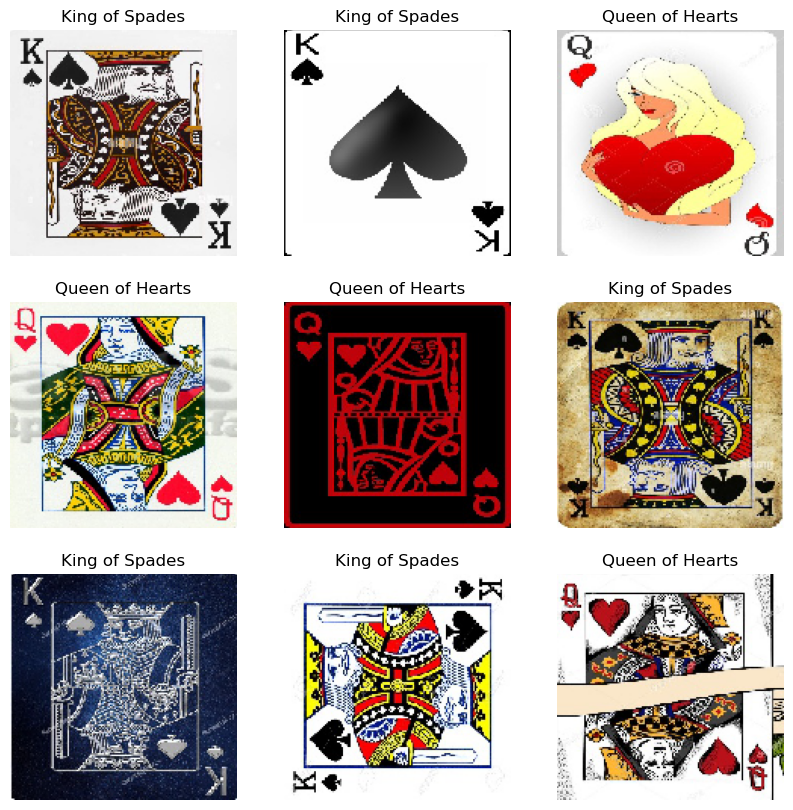

In [2]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the path to the training dataset
train_path = r'cards/train/'

# Create an ImageDataGenerator for loading and augmenting images
datagen = ImageDataGenerator(rescale=1./255)

# Flow images from the specified directory
train_generator = datagen.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

# Extract a batch of images and labels from the generator
sample_images, sample_labels = next(iter(train_generator))

# Define label names
label_names = {0.0: 'King of Spades', 1.0: 'Queen of Hearts'}

# Display a 3x3 grid of sample images with their corresponding labels
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(sample_images[i])
    
    # Convert label to name
    label_name = label_names[sample_labels[i]]
    
    plt.title(f"{label_name}")
    plt.axis('off')

plt.show()

Feature Engineering.

In [3]:
Train_ds = ImageDataGenerator(rescale=1./255.)
Test_ds = ImageDataGenerator(rescale=1./255.)
Valid_ds = ImageDataGenerator(rescale=1./255.)

Train_ds = Train_ds.flow_from_directory(
	"cards/train",
	target_size=(150,150),
	class_mode='binary',
  batch_size=126,
	shuffle=False
)

Valid_ds = Valid_ds.flow_from_directory(
	"cards/valid",
	target_size=(150,150),
	class_mode='binary',
  batch_size=126,
	shuffle=False
)

Test_ds = Test_ds.flow_from_directory(
	"cards/test",
	target_size=(150,150),
	class_mode='binary',
  batch_size=126,
	shuffle=False
)

Found 10 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


Found 10 images belonging to 2 classes.


In [4]:
print(Train_ds.class_indices)
print(Test_ds.class_indices)

{'king of spades': 0, 'queen of hearts': 1}
{'king of spades': 0, 'queen of hearts': 1}


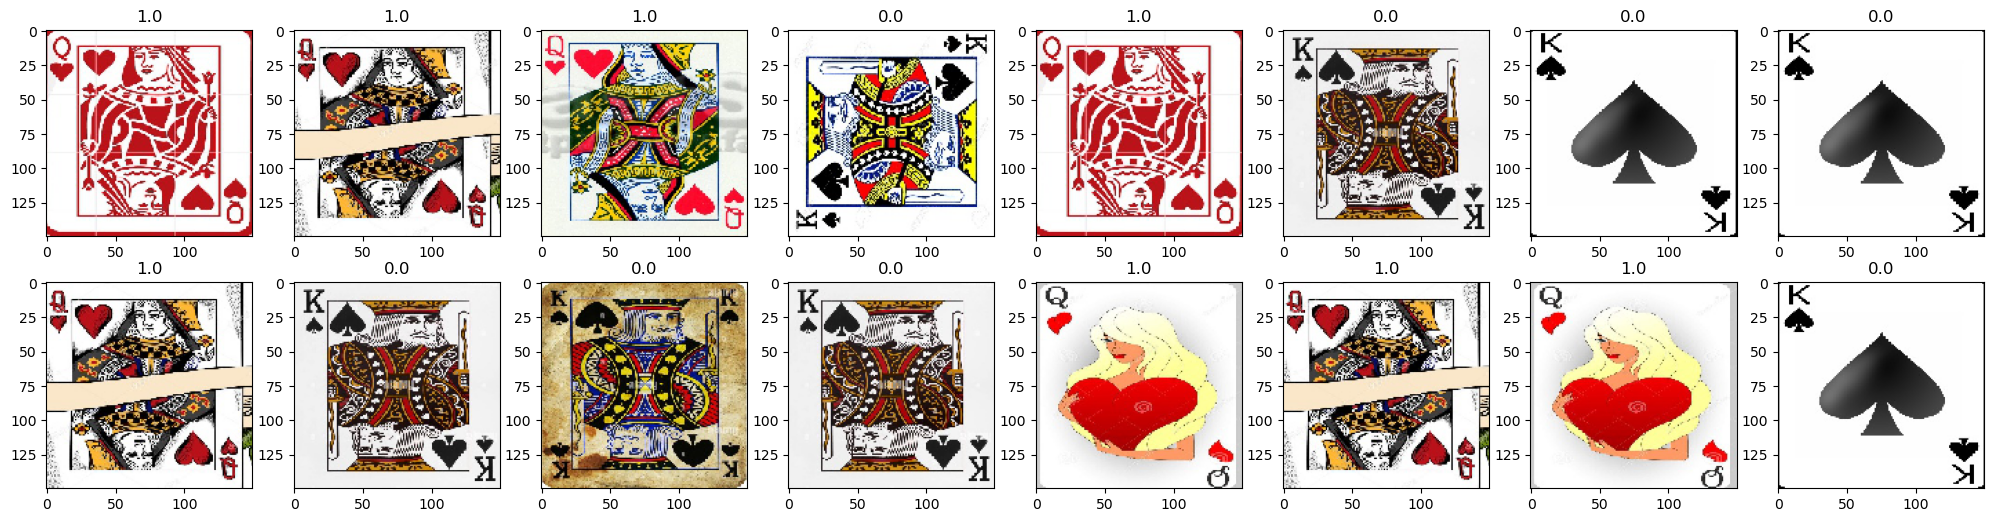

In [5]:
fig,ax = plt.subplots(nrows=2,ncols=8,figsize=(25,6))
n = 0
idx = np.random.randint(len(Train_ds.next()[0]), size=16)
for i in range(2):
  for j in range(8):
    img = Train_ds.next()[0][idx[n]]
    ax[i][j].imshow(img)
    ax[i][j].set_title(Train_ds.next()[1][idx[n]])
    n+=1

---

Model Definition.

In [6]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(32, (3,3),activation='relu', input_shape=(150, 150, 3)))
model.add(tf.keras.layers.MaxPooling2D(2, 2))
model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2, 2))
model.add(tf.keras.layers.Conv2D(128, (3,3),activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2, 2))
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

---

Flatten.

In [8]:
model1 = tf.keras.models.Sequential()

model1.add(tf.keras.layers.Conv2D(32, (3,3),activation='relu', input_shape=(150, 150, 3)))
model1.add(tf.keras.layers.MaxPooling2D(2, 2))
model1.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
model1.add(tf.keras.layers.MaxPooling2D(2, 2))
model1.add(tf.keras.layers.Conv2D(128, (3,3),activation='relu'))
model1.add(tf.keras.layers.MaxPooling2D(2, 2))
model1.add(tf.keras.layers.Flatten())
model1.add(tf.keras.layers.Dropout(0.5))
model1.add(tf.keras.layers.Dense(512, activation='relu'))
model1.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [9]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 17, 17, 128)      

In [10]:
# Checkpointing and early stopping
from keras.src.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

callbacks1= [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('model_check.h5', save_best_only= True )
]

---

Model Training.